In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
import torch
version = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try:
    import torch_geometric
except:
    !echo $version
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $version
    import torch_geometric

In [3]:
import torch


In [14]:
from torch_geometric.datasets import ShapeNet
dataset = ShapeNet(root=".", categories=["Rocket", "Pistol", "Guitar", "Car", "Mug", "Knife", "Table", "Airplane"]).shuffle()[:5000]
print("Number of Samples: ", len(dataset))
print("Sample: ", dataset[0])

Processing...
Done!


Number of Samples:  5000
Sample:  Data(x=[2620, 3], y=[2620], pos=[2620, 3], category=[1])


In [15]:
dataset[0].pos

tensor([[-0.1820,  0.1748, -0.3896],
        [-0.0661,  0.1738, -0.3676],
        [-0.1413,  0.1738, -0.3953],
        ...,
        [ 0.1746,  0.1751, -0.2967],
        [-0.0851,  0.1741,  0.4094],
        [ 0.0214,  0.1709,  0.4094]])

In [6]:
!pip install plotly --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.1 MB/s eta 0:00:00


In [17]:
import plotly.express as px

def plot_3d_shape(shape):
    print("Number of data points: ", shape.x.shape[0])
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 15
plot_3d_shape(dataset[sample_idx])

Number of data points:  2781


In [18]:
cat_dict = {key: 0 for key in dataset.categories}
for cat in dataset: cat_dict[dataset.categories[cat.category.int()]]+=1
cat_dict

{'Rocket': 21,
 'Pistol': 143,
 'Guitar': 360,
 'Car': 441,
 'Mug': 79,
 'Knife': 177,
 'Table': 2457,
 'Airplane': 1322}

# Data Augmentation

In [19]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
augmentation = T.Compose([T.RandomJitter(0.03), T.RandomFlip(1), T.RandomShear(0.2)])

In [22]:
sample = next(iter(data_loader))
plot_3d_shape(sample[15])

Number of data points:  2547


In [23]:
transformered = augmentation(sample)
plot_3d_shape(transformered[15])

Number of data points:  2547


# Model

In [24]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        self.lin1 = Linear(128 + 64, 128)
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))

            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

In [25]:
!pip install pytorch-metric-learning -q

from pytorch_metric_learning.losses import NTXentLoss
loss_func = NTXentLoss(temperature=0.10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [27]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        embeddings = torch.cat((compact_h_1, compact_h_2))
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 4):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 157/157 [06:28<00:00,  2.47s/it]


Epoch 001, Loss: 1.3297


100%|██████████| 157/157 [06:28<00:00,  2.47s/it]


Epoch 002, Loss: 0.6214


100%|██████████| 157/157 [06:28<00:00,  2.47s/it]

Epoch 003, Loss: 0.2488


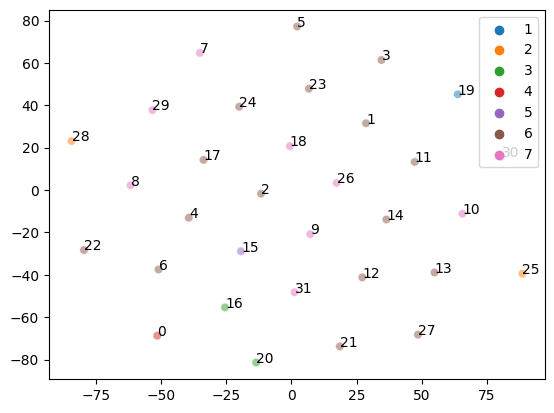

In [28]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sample = next(iter(data_loader))

h = model(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.category.cpu().detach().numpy()

h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels,
                    alpha=0.5, palette="tab10")

annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]),
            pd.Series(h_embedded[:,1]),
            pd.Series(annotations),
            plt.gca())

In [32]:
import numpy as np

def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

idx = 10
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")

Most similar data point in the embedding space for 10 is 18


In [33]:
plot_3d_shape(sample[idx].cpu())

Number of data points:  2624


In [34]:
plot_3d_shape(sample[similar_idx].cpu())

Number of data points:  2547
